# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns


In [3]:
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,31.4063249191152,238.23046101526165
2000,34.69606879106351,268.89676224515244


In [6]:
os.path.join(workdir, "butane_sim.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_sim.xtc'

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,47.65068101175835,291.5692549527442,--
500000,999.9999999901769,38.019898064327734,202.0978783817628,8.59e+03
750000,1499.9999999783536,29.824031830683307,271.42940426957966,7.77e+03
1000000,1999.9999999665301,45.630033291421164,201.55033238649912,7.71e+03
1250000,2499.9999999547067,55.15630354777428,293.0418411758392,7.17e+03
1500000,2999.9999999428833,26.82225810104022,328.37760798776605,6.82e+03
1750000,3499.99999993106,69.9804678127653,187.51092738743304,6.93e+03
2000000,3999.9999999192364,54.28006591864563,237.73865563330446,6.79e+03
2250000,4499.9999999992715,29.462993299218574,246.05546170923193,6.8e+03
2500000,5000.000000101135,23.77108393991722,310.82376924179584,6.7e+03
2750000,5500.000000202998,50.21575889273784,442.1327363693143,6.68e+03
3000000,6000.000000304862,59.25826221906057,307.6047459258968,6.66e+03
3250000,6500.000000406725,23.248807270

In [8]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x1b221e34d50>

In [9]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [10]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x1b220179710>

In [11]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [12]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


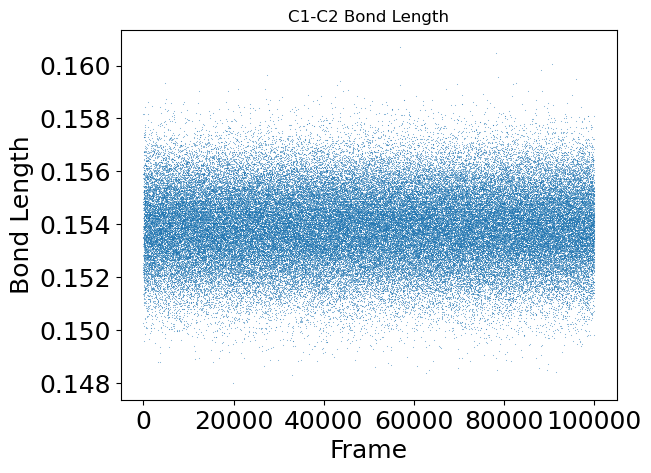

In [13]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000]) ## used to set the limit of the axis

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

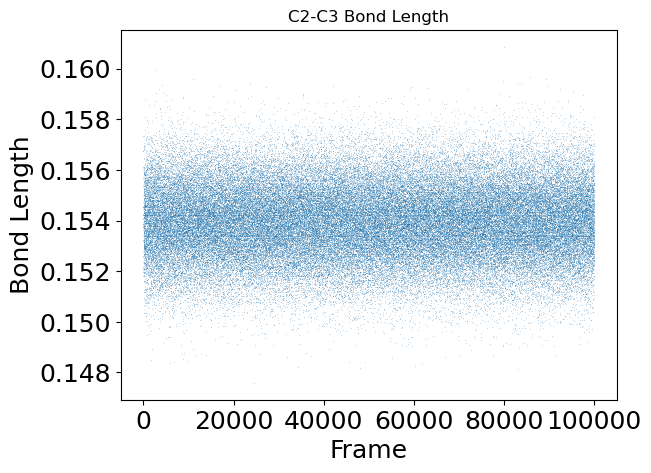

In [14]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

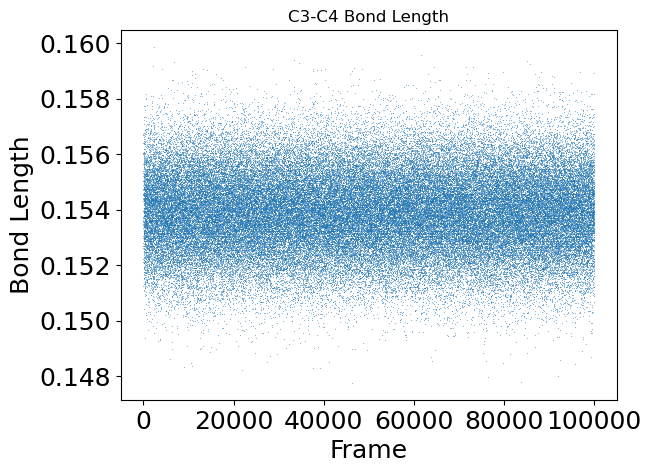

In [15]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

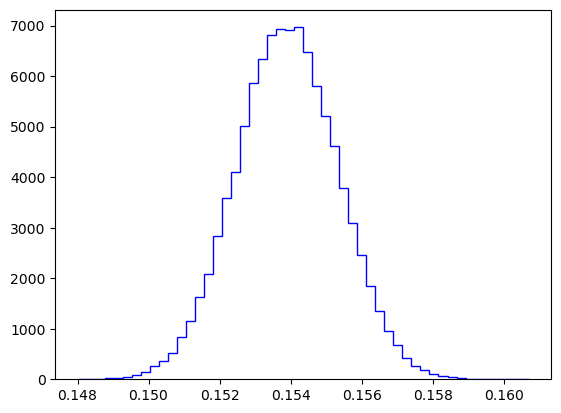

In [16]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

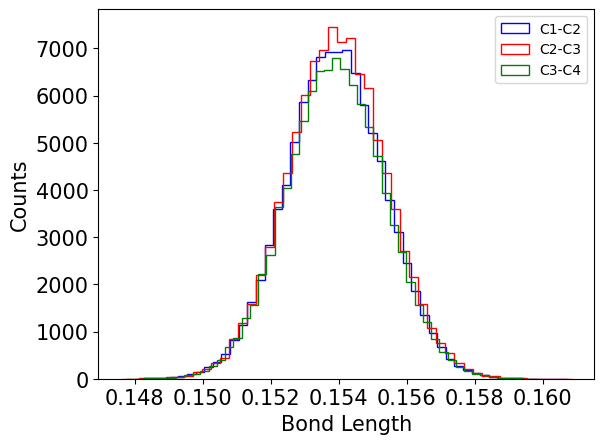

In [17]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [18]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 2.0572288e-06 C1-C2 standard deviation: 0.0014343042955353546
C2-C3 variance: 2.0652672e-06 C1-C2 standard deviation: 0.001437103737988011
C3-C4 variance: 2.0652672e-06 C1-C2 standard deviation: 0.0014299640402773458


In [19]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15390222 variance: 2.0572288e-06 std-dev: 0.0014343043
C2-C3 average: 0.15394513 variance: 2.0652672e-06 std-dev: 0.0014371037
C3-C4 average: 0.1539061 variance: 2.0447972e-06 std-dev: 0.0014299641


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [20]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\IPython\core\interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Line Parameters: [0.5001153 0.0769722]


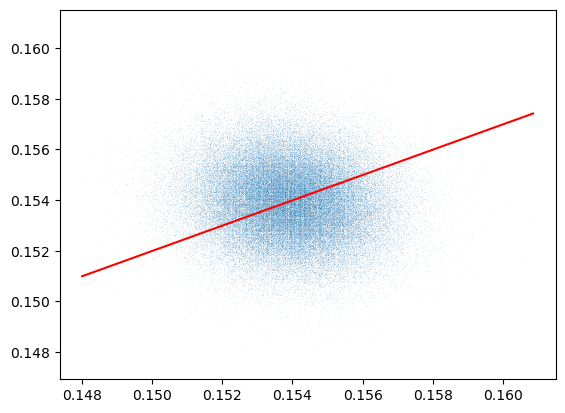

r2: -0.10968292580846506
Line Parameters: [0.49999114 0.07695309]


C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\IPython\core\interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


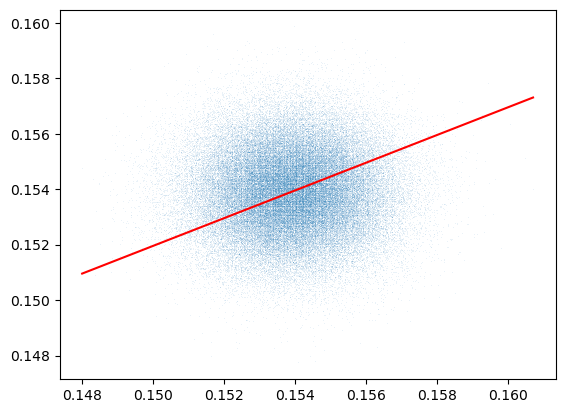

r2: 0.009773421516034728


In [21]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

<Figure size 640x480 with 0 Axes>

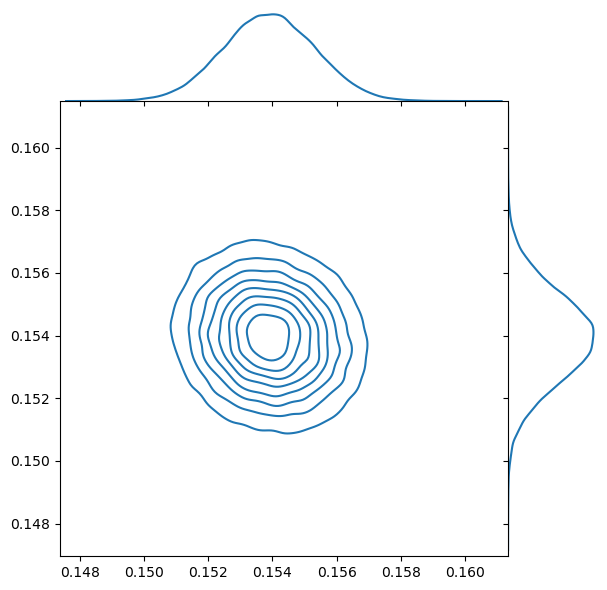

In [22]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

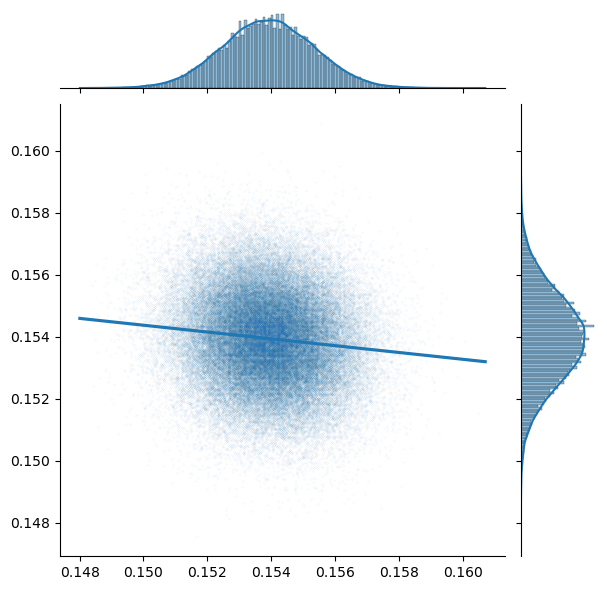

In [23]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

HERE IS MY ANSWER - The calculated coefficient of correlation for C1C2/C2C3 bond pair (A) is r^2: -0.1088523445317443 and that of C1C2/C3C4 bond pair (B) is r^2: 0.012420380154027818. from the results, A is more correlated than B since the r^2 value observed for A is close to -1 than the r^2 value observed for B being close to 1. This observation makes A more correlated than B, and this can be due to the stearic hinderance between the hydrogen atoms of A. Since they share a common carbon atom (C2), the rotation angles could results in a greater stearic hinderance when a fully eclipse conformation is obtained as opposed to B which doesn't share a common attom.  

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

[    0     1    33   101   432  1218  3195  6748 11351 16091 17686 16606
 12473  7784  4001  1553   528   159    31     6] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.1792625663722991 x_0: 0.1538988008642338 fit_sigma: -0.0014476699772386933


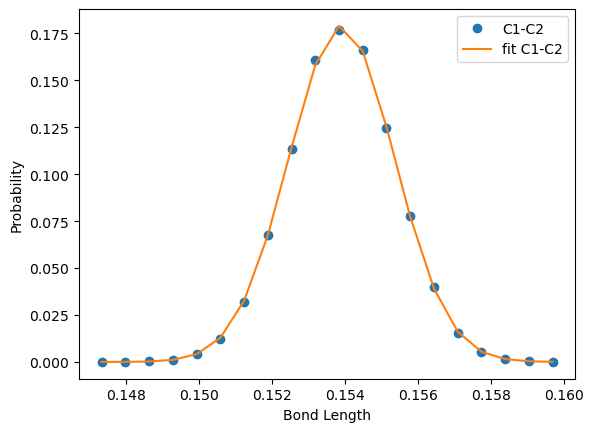

In [24]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.1792625663722991 x_0: 0.1538988008642338 fit_sigma: -0.0014476699772386933
a: 0.17910944774716464 x_0: 0.1539428013068872 fit_sigma: -0.0014480693695334208
a: 0.17955753654513337 x_0: 0.1539021203423968 fit_sigma: -0.0014460458673914108


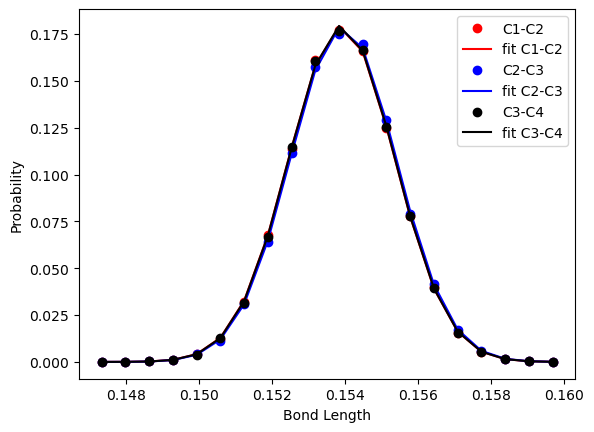

In [25]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
#def histogram_bincenters:
def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum
   
####ADD YOUR CODE HERE #####
#  return centers,density 
    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density

#USE THE FUNCTION TO ITERATE OVER ALL CC BONDS, plot the densities and the fits
# get centers and density for C1C2bondlength
centers, density = histogram_bincenters(C1C2bondlength, a_bins=20, a_range=[0.147,0.160])
C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o',color= 'red', label='C1-C2')
plt.plot(centers,C1C2_fit,'-', color= 'red', label='fit C1-C2')

# get centers and density for C2C3bondlength
centers, density = histogram_bincenters(C2C3bondlength, a_bins=20, a_range=[0.147,0.160])
C2C3_fit,C2C3_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o', color= 'blue', label='C2-C3')
plt.plot(centers,C2C3_fit,'-',color= 'blue', label='fit C2-C3')

# get centers and density for C3C4bondlength
centers, density = histogram_bincenters(C3C4bondlength, a_bins=20, a_range=[0.147,0.160])
C3C4_fit,C3C4_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o',color= 'black', label='C3-C4')
plt.plot(centers,C3C4_fit,'-',color= 'black', label='fit C3-C4')


# this is for the general plot 
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

In [26]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#TRY THIS FUNCTION:
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
#ADD CODE FOR CDFs HERE#   

def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum

    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density
    
def pdf_to_cdf(density):
    
     # Calculate the cumulative sum of the density
    cumulative_density = np.cumsum(density)

    return cumulative_density

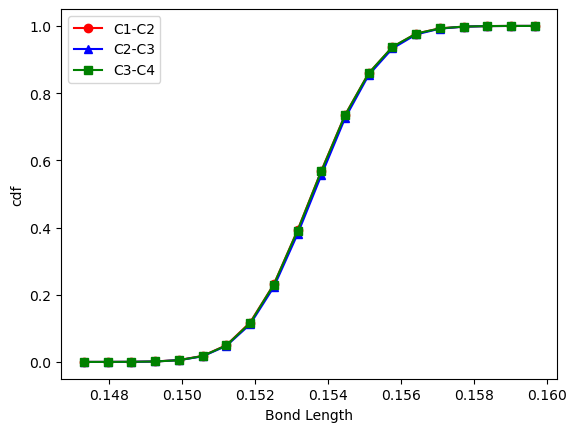

In [27]:
# get cdf for C1C2bondlength
centers, density = histogram_bincenters(C1C2bondlength, a_bins=20, a_range=[0.147, 0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf, 'o', linestyle="-", color= 'red', label='C1-C2')

# get cdf for C2C3bondlength
centers, density = histogram_bincenters(C2C3bondlength, a_bins=20, a_range=[0.147,0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf,'^', linestyle="-", color= 'blue', label='C2-C3')

# get cdf for C3C4bondlength
centers, density = histogram_bincenters(C3C4bondlength, a_bins=20, a_range=[0.147,0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf,'s', linestyle="-", color= 'green', label='C3-C4')

# this is for the general plot 
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('cdf')
plt.show()



**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle.  Why is the Gaussian fit for a dihedral so poor with a large sample? ***


![image.png](attachment:image.png)

Frame number selected: 10
a: 0.17125685476192978 x_0: 0.1536034918487269 fit_sigma: -0.0015013008220520873
a: -1.6644222312674317 x_0: -1.7851906458664422 fit_sigma: 0.13967568623674187
a: 1.265795879401502 x_0: 0.6737853249557721 fit_sigma: 0.04903848178953363


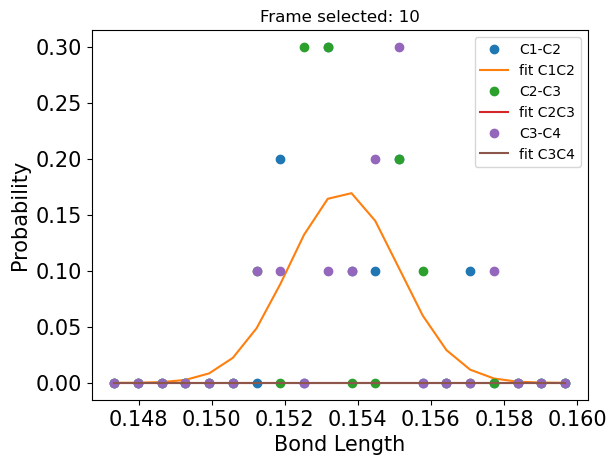

Frame number selected: 100
a: 0.17916223208470697 x_0: 0.153961863767671 fit_sigma: -0.0014543821461471562
a: 0.18329289652119024 x_0: 0.15372575508027236 fit_sigma: -0.0013790654180077819
a: 0.21712955547907317 x_0: 0.15396694528028076 fit_sigma: -0.0012183446423903435


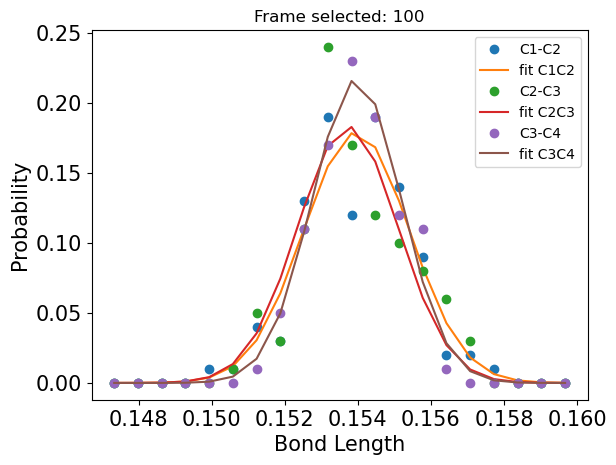

Frame number selected: 1000
a: 0.18074978388546187 x_0: 0.15395146316764347 fit_sigma: -0.0014256923816573668
a: 0.18480363286642476 x_0: 0.1539646115500418 fit_sigma: 0.0014001374683772925
a: 0.1885816540765068 x_0: 0.15387446068705035 fit_sigma: -0.0013687885679228816


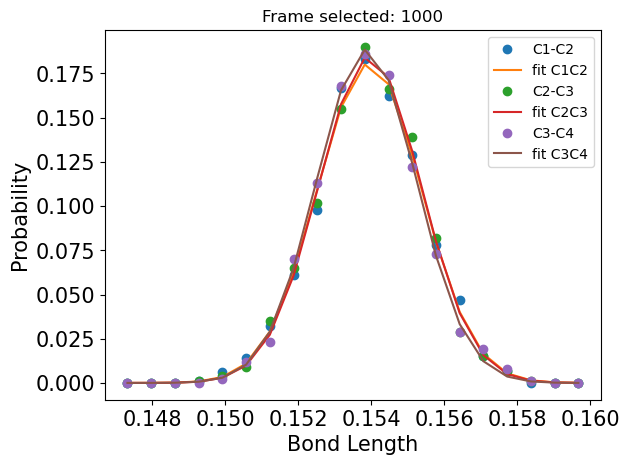

Frame number selected: 10000
a: 0.18216463370631403 x_0: 0.15385644709307345 fit_sigma: 0.001418915086824318
a: 0.17557825715131925 x_0: 0.15395877914473455 fit_sigma: -0.0014759643169896667
a: 0.1769447862603823 x_0: 0.15391696207863792 fit_sigma: -0.0014716635071630854


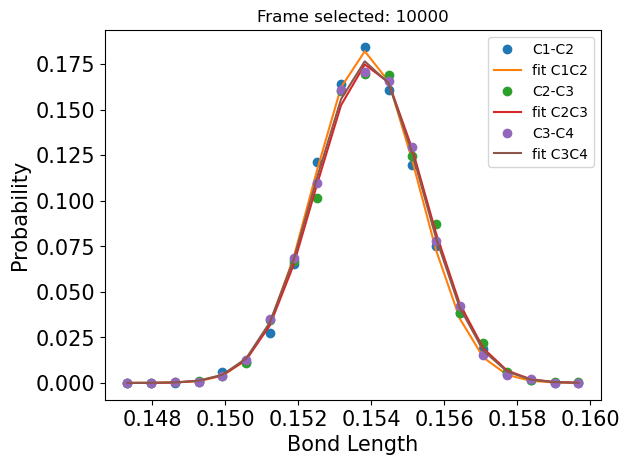

<Figure size 640x480 with 0 Axes>

In [31]:
#Draw 10,100,1000 random samples of a bond angle,
#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands
#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum

    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density
    
centers, density = histogram_bincenters(C1C2bondlength, 20, [0.147, 0.160])

#This function might be helpful:
frame_length = [10,100,1000,10000]
for i in frame_length:
    rands=np.random.randint(10000, size=(i))
    print('Frame number selected: ' + str(i))

    C1C2_A = C1C2bondlength[rands]
    centers, density = histogram_bincenters(C1C2_A, 20, [0.147, 0.160])
    C1C2_A_fit, C1C2_A_fit_params = fit_gauss(centers,density)
    plt.plot(centers, density, 'o', label = 'C1-C2')
    plt.plot(centers, C1C2_A_fit, '-', label='fit C1C2')
    
    C2C3_A = C2C3bondlength[rands]
    centers, density = histogram_bincenters(C2C3_A, 20, [0.147, 0.160])
    C2C3_A_fit, C2C3_A_fit_params = fit_gauss(centers, density)
    plt.plot(centers, density, 'o', label = 'C2-C3')
    plt.plot(centers, C2C3_A_fit, '-', label='fit C2C3')
    
    C3C4_A = C3C4bondlength[rands]
    centers, density = histogram_bincenters(C3C4_A, 20, [0.147, 0.160])
    C3C4_A_fit, C3C4_A_fit_params = fit_gauss(centers, density)  
    plt.plot(centers, density, 'o', label = 'C3-C4')
    plt.plot(centers, C3C4_A_fit, '-', label='fit C3C4')
    
    plt.legend()
   
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Bond Length', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    
    plt.show()
    plt.clf()

(array([1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2.,
        0., 0., 2.]),
 array([0.15160802, 0.15179776, 0.15198749, 0.15217723, 0.15236697,
        0.15255669, 0.15274642, 0.15293616, 0.1531259 , 0.15331563,
        0.15350537, 0.15369511, 0.15388484, 0.15407458, 0.15426432,
        0.15445405, 0.15464377, 0.15483351, 0.15502325, 0.15521298,
        0.15540272]),
 [<matplotlib.patches.Polygon at 0x1b22ba005d0>])

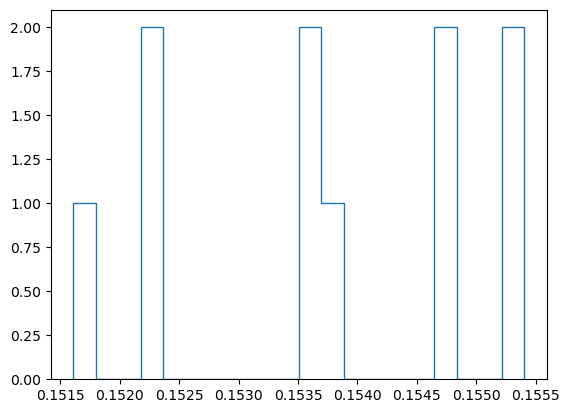

In [32]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

#This function might be helpful:
rands=np.random.randint(100000, size=(10))
rands
C1C2bond=C1C2bondlength[:,0]
C1C2bond[rands]
plt.hist(C1C2bond[rands],bins=20,histtype='step')
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?

In [33]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.994056  1.9144654]
 [1.86548   1.8920181]
 [2.088623  2.0899951]
 ...
 [1.9526802 1.9268394]
 [2.020191  1.9771874]
 [1.9127874 1.9691658]]


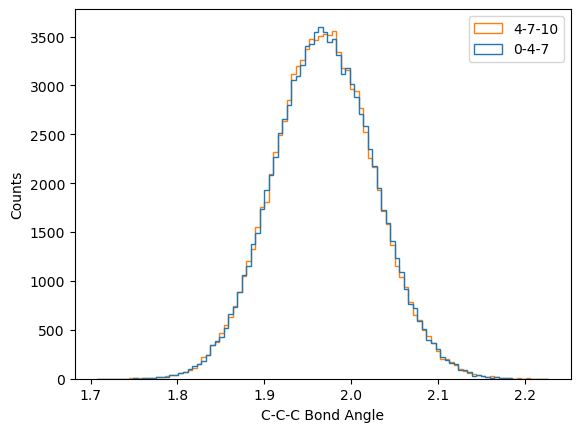

[[ 3.0880637]
 [-2.9362698]
 [ 2.8263943]
 ...
 [ 3.0656958]
 [ 3.0015318]
 [ 3.0314605]]
[[ 176.93301]
 [-168.23586]
 [ 161.94046]
 ...
 [ 175.65141]
 [ 171.9751 ]
 [ 173.68988]]


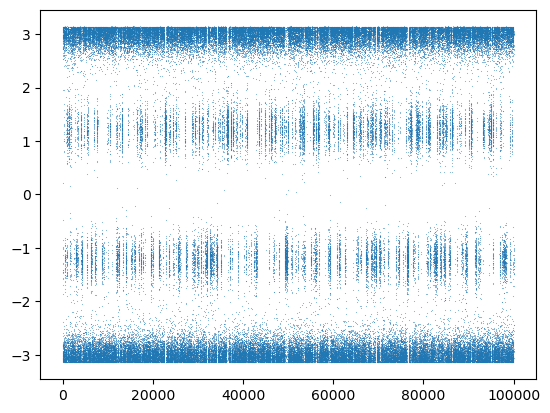

In [34]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

Frame number selected:  10
[0.64907663 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.32453832 0.         0.         0.
 0.32453832 1.9472299 ] [-3.036861   -2.728731   -2.420601   -2.112471   -1.8043411  -1.496211
 -1.188081   -0.8799511  -0.5718211  -0.26369113  0.04443884  0.3525688
  0.6606988   0.9688288   1.2769587   1.5850887   1.8932188   2.2013488
  2.5094786   2.8176086   3.1257386 ]
a: 0.6442491834711082 x_0: 2.921297211115366 fit_sigma: -0.1335342027683591


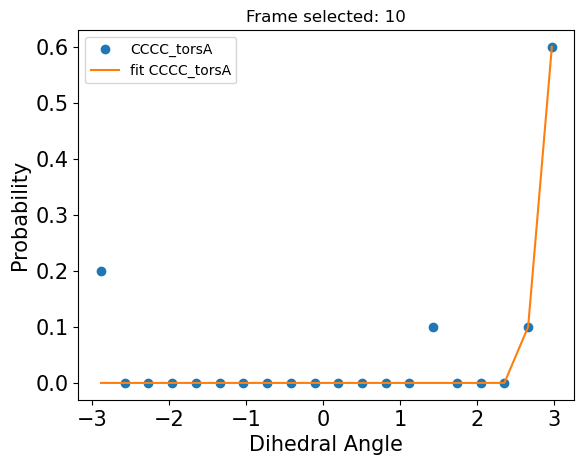

Frame number selected:  100
[1.1811326  0.28730274 0.03192253 0.         0.         0.12769006
 0.15961257 0.         0.03192251 0.         0.         0.
 0.         0.         0.09576754 0.         0.         0.03192253
 0.09576758 1.14921009] [-3.1327291e+00 -2.8194704e+00 -2.5062120e+00 -2.1929536e+00
 -1.8796949e+00 -1.5664364e+00 -1.2531779e+00 -9.3991935e-01
 -6.2666082e-01 -3.1340230e-01 -1.4376640e-04  3.1311476e-01
  6.2637329e-01  9.3963182e-01  1.2528903e+00  1.5661489e+00
  1.8794074e+00  2.1926661e+00  2.5059245e+00  2.8191829e+00
  3.1324415e+00]
a: 0.7127513230288066 x_0: -3.3795014113993114 fit_sigma: 0.3522839389467664


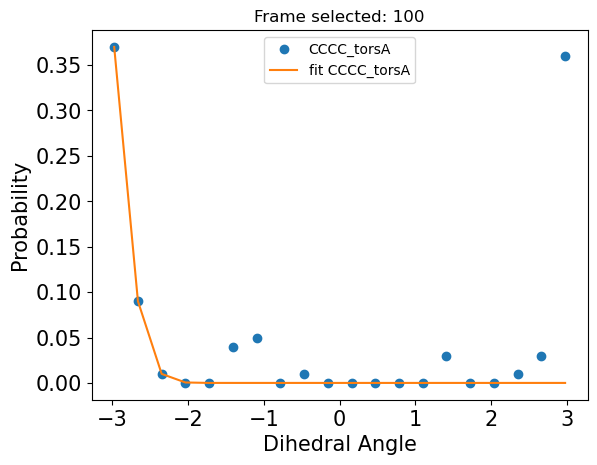

Frame number selected:  1000
[1.22594287 0.18787176 0.02228985 0.01592134 0.01273707 0.11781789
 0.10508078 0.04776401 0.00636853 0.         0.         0.
 0.03184267 0.07960665 0.10826508 0.01592134 0.         0.02547412
 0.14329202 1.0380711 ] [-3.1408784e+00 -2.8268344e+00 -2.5127904e+00 -2.1987462e+00
 -1.8847022e+00 -1.5706582e+00 -1.2566142e+00 -9.4257009e-01
 -6.2852609e-01 -3.1448203e-01 -4.3797493e-04  3.1360608e-01
  6.2765014e-01  9.4169414e-01  1.2557383e+00  1.5697823e+00
  1.8838263e+00  2.1978703e+00  2.5119145e+00  2.8259585e+00
  3.1400025e+00]
a: 233721.50160145265 x_0: -7.595166533911479 fit_sigma: -0.8935425568827052


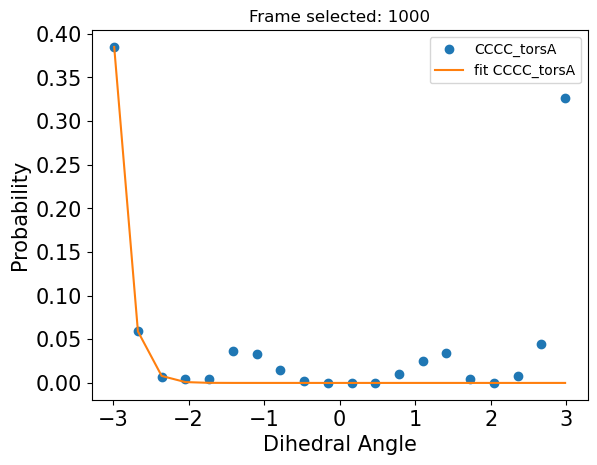

Frame number selected:  10000
[1.11632164e+00 1.95443822e-01 1.55973083e-02 4.45637210e-03
 2.06903069e-02 1.23823529e-01 1.38465874e-01 3.91524269e-02
 4.13806099e-03 0.00000000e+00 6.36624767e-04 4.77468575e-03
 3.18312414e-02 1.06952951e-01 9.32655372e-02 1.84621200e-02
 5.41130898e-03 2.22818690e-02 1.97035384e-01 1.04438303e+00] [-3.1415455e+00 -2.8273888e+00 -2.5132320e+00 -2.1990752e+00
 -1.8849183e+00 -1.5707616e+00 -1.2566048e+00 -9.4244796e-01
 -6.2829119e-01 -3.1413439e-01  2.2411346e-05  3.1417921e-01
  6.2833601e-01  9.4249278e-01  1.2566496e+00  1.5708064e+00
  1.8849632e+00  2.1991200e+00  2.5132768e+00  2.8274336e+00
  3.1415904e+00]
a: 1.2181278156634856 x_0: -3.5566140673571827 fit_sigma: -0.3625634787788157


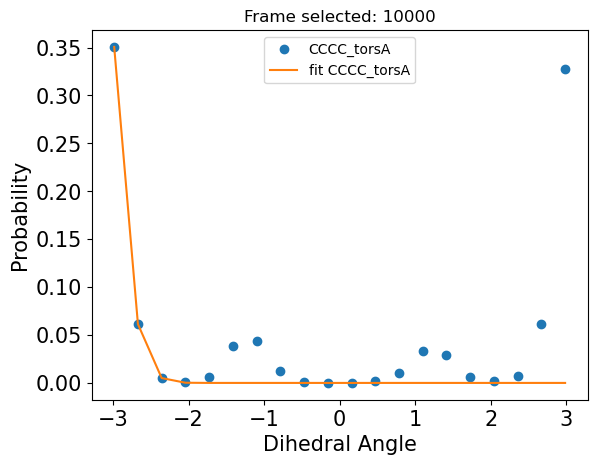

<Figure size 640x480 with 0 Axes>

In [38]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

def histogram_bincenters(CCCC_torsA, bins=20):
    counts, edges = np.histogram(CCCC_torsA, bins=bins, density=True)
    print(counts,edges)
    centers = (edges[:-1] + edges[1:])/2
    density=counts/(np.sum(counts))
    return centers, density

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x, y):
    parameters, covariance = curve_fit(gauss, x, y, maxfev=10000)  # Increase maxfev
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:", fit_a, "x_0:", fit_x0, "fit_sigma:", fit_sigma)
    fit_y = gauss(x, fit_a, fit_x0, fit_sigma)
    return fit_y, [fit_a, fit_x0, fit_sigma]

#This function might be helpful:
frame_length = [10,100,1000,10000]
for i in frame_length:
    rands=np.random.randint(10000, size=i)
    print('Frame number selected: ', i)

#CCCC_index=[10,7,4,0]
#CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
    #CCCC_torsion[rands]
    #print(CCCC_torsion)
    #print(np.rad2deg(CCCC_torsion))

    CCCC_torsA = CCCC_torsion[rands]
    centers, density = histogram_bincenters(CCCC_torsA, bins=20,)
    CCCC_torsA_fit, CCCC_torsA_fit_params = fit_gauss(centers,density)
    plt.plot(centers, density, 'o', label = 'CCCC_torsA')
    plt.plot(centers, CCCC_torsA_fit, '-', label='fit CCCC_torsA')

    plt.legend() 
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Dihedral Angle', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    plt.show()
    plt.clf()

#plt.plot(CCCC_torsion[rands],marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

The poor Gaussian fit results from the multimodal characteristics of butane since it can exist in different conformations.
A Gaussian fit assumes a unimodal symmetric distribution, so it cannot accurately capture the calculated dihedral angles of butane.
Multiple peaks are observed within the 100, 1000, and 10000 random sample plots. For the plot of a sample size of 10, the poor Gaussian fit may result from the outliers and the small sample size. 

(0.0, 1000.0)

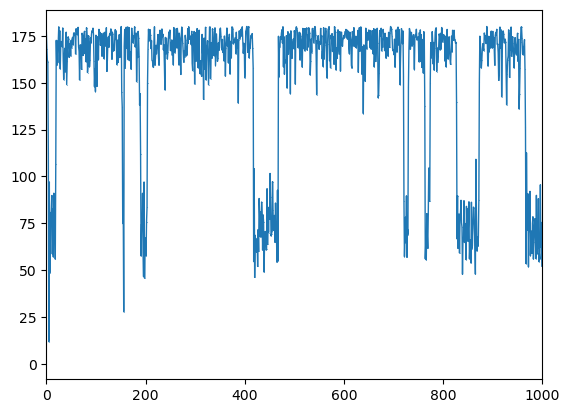

In [39]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
    #if(CCCC_tor_offset[i]<0):
        #CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [40]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)

#Probability of being between 0 and -2 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))


(array([    1,     3,     6, ..., 99991, 99994, 99995], dtype=int64),)
[-2.9362698 -2.8145323 -1.6933472 ... -2.4355528 -2.5466535 -2.8816142]
(array([    0,     2,     4, ..., 99997, 99998, 99999], dtype=int64),)
(array([    6,     7,     8, ..., 99977, 99978, 99979], dtype=int64),)
0.10664


In [41]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe>0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe<5)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe>0) & (CCCC_dihe<5)) # use this function
print(c)
#
# high probability = high energy = unstable (vice versa) 
## what we want to do is show that is has a high energy and the probability of finding something there is low 
#Probability of being between 0 and 5 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    0,     2,     4, ..., 99997, 99998, 99999], dtype=int64),)
[3.0880637 2.8263943 1.9608796 ... 3.0656958 3.0015318 3.0314605]
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
(array([    0,     2,     4, ..., 99997, 99998, 99999], dtype=int64),)
0.50102


In [42]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
### Highest energy would be found at 0 rad and 6.25 (360 degrees). but 360 degrees doesn't technically exist so we 
###calculate around the 0 degrees or radiance
 
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-0.1)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-0.1)) # use this function
print(c)
#
# low probability = high energy = unstable (vice versa) 
## What we want to do is show that it has high energy and the probability of finding something there is low 
#Probability of being between 0 and -0.1 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    1,     3,     6, ..., 99991, 99994, 99995], dtype=int64),)
[-2.9362698 -2.8145323 -1.6933472 ... -2.4355528 -2.5466535 -2.8816142]
(array([    0,     2,     4, ..., 99997, 99998, 99999], dtype=int64),)
(array([59190], dtype=int64),)
1e-05


In [43]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe>-6.28)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe<6.28)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe>-6.28) & (CCCC_dihe<6.28)) # use this function
print(c)
#
# low probability = high energy = unstable (vice versa) 
## what we want to do is show that is has a high energy and the probability of finding something there is low 
#Probability of being between -6,28 and 6.28 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
[ 3.0880637 -2.9362698  2.8263943 ...  3.0656958  3.0015318  3.0314605]
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
1.0


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.0018255691160413952


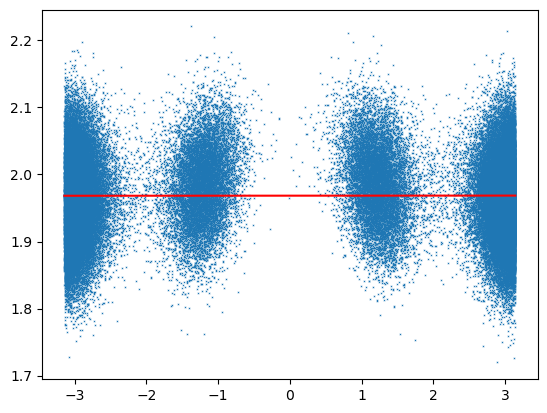

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

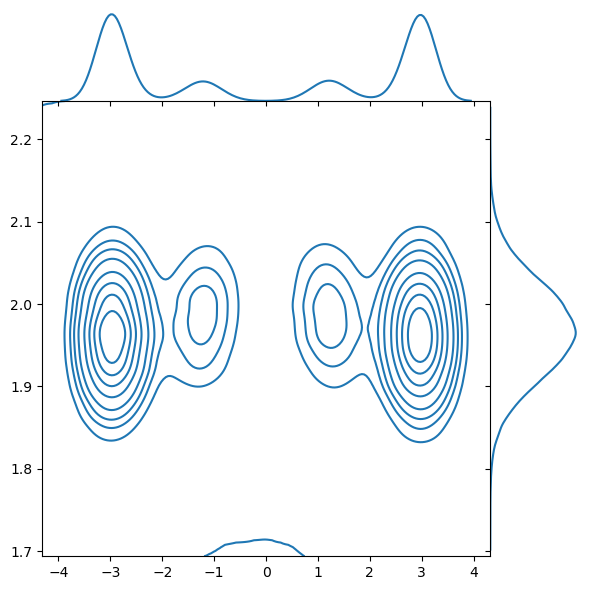

In [45]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

In [46]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]

(array([    1,     3,     6, ..., 99991, 99994, 99995], dtype=int64),)
(array([    0,     2,     4, ..., 99997, 99998, 99999], dtype=int64),)
(array([    6,     7,     8, ..., 99977, 99978, 99979], dtype=int64),)


array([-1.6933472 , -0.84700036, -1.1355124 , ..., -1.0654948 ,
       -1.039585  , -1.7084967 ], dtype=float32)

In [47]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.994056  1.86548   2.088623  ... 1.9526802 2.020191  1.9127874]
[1.86548   2.088623  2.018807  ... 1.9526802 2.020191  1.9127874]
[1.994056  1.86548   2.088623  ... 1.8983017 1.9526802 2.020191 ]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


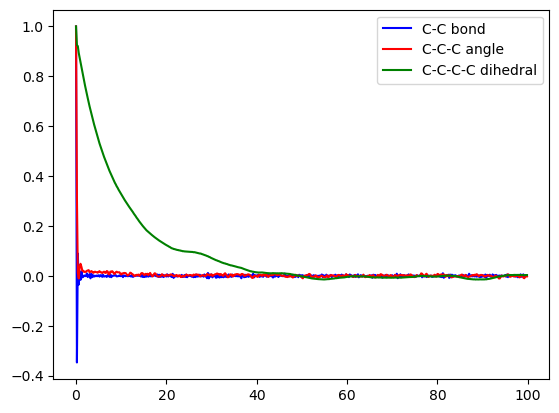

In [48]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

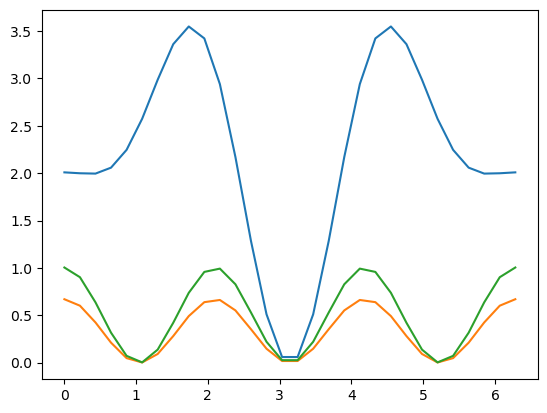

In [49]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)


##Lets write a function to plot the values of force field terms
def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

In [50]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [51]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13) why is there a dash between the first bracket and C4 but all others have the C in front of the bracket without a dash?
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


In [52]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[ 3.0987449  -1.2255108   1.0047188  ... -1.2909724   0.8364315
   2.8597045 ]
 [-2.8883224  -0.85756695  1.389633   ... -0.8095613   1.1347482
  -2.9612207 ]
 [ 2.5647304  -1.6572573   0.6572477  ... -0.7496513   1.3797297
  -2.625296  ]
 ...
 [ 3.0114963  -1.222108    0.95621806 ...  1.0648249   3.0706882
  -0.9770754 ]
 [ 3.0648258  -1.2123951   1.0963774  ...  0.9219682   2.9916892
  -1.2051345 ]
 [ 2.8628173  -1.3906813   1.0824337  ...  1.0531925   3.0811698
  -0.9910075 ]]


In [54]:
print(CCCH_indices)
print(CCCH_torsions)

([10, 7, 4, 1], [10, 7, 4, 2], [10, 7, 4, 2], [4, 7, 10, 13], [4, 7, 10, 12], [4, 7, 10, 13])
[[ 2.9004192 -2.613709  -2.613709   0.8328929  2.9602969  0.8328929]
 [-2.8784583 -2.5624945 -2.5624945  1.408904  -2.929972   1.408904 ]
 [ 2.9732852 -3.0718749 -3.0718749  1.2096578 -2.9441464  1.2096578]
 ...
 [-2.7730663  2.58712    2.58712   -3.0578737 -1.0520103 -3.0578737]
 [-2.7840793  2.6826475  2.6826475 -3.0445812 -0.9748601 -3.0445812]
 [-2.8544085  2.6743517  2.6743517 -3.0454602 -1.017483  -3.0454602]]


In [53]:
print(CCCC_index)
print(CCCC_torsion)

[10, 7, 4, 0]
[[ 3.0880637]
 [-2.9362698]
 [ 2.8263943]
 ...
 [ 3.0656958]
 [ 3.0015318]
 [ 3.0314605]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

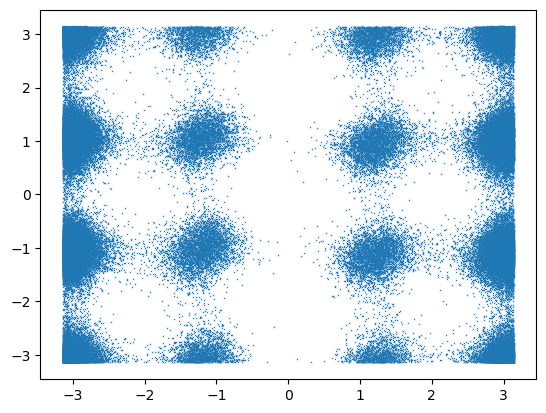

<Figure size 640x480 with 0 Axes>

In [55]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]



#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

#For Example:
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)
plt.show()
plt.clf()


Line Parameters: [0.0141758  0.08003233]
r2: 0.020202184221132836


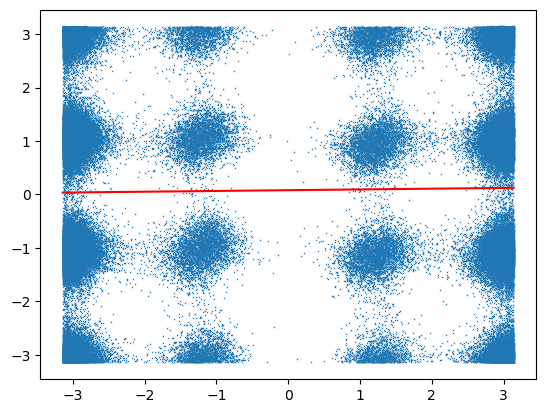

<Figure size 640x480 with 0 Axes>

In [56]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]



#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,14],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,14]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,14])
print("r2:",r[0,1])

#For Example:
plt.show()
plt.clf()

Line Parameters: [ 0.01747821 -0.05642234]
r2: 0.024845826979840693


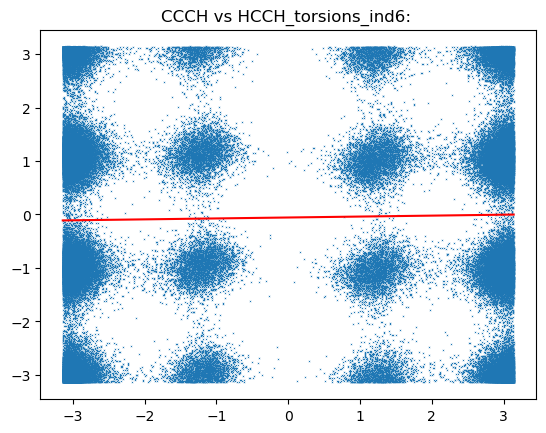

<Figure size 640x480 with 0 Axes>

In [57]:
plt.scatter(CCCC_torsion[:,0], HCCH_torsions[:,6],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,6],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,6]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,6])
print("r2:",r[0,1])
plt.title('CCCH vs HCCH_torsions_ind6: ')
plt.show()
plt.clf()

Line Parameters: [ 0.62914957 -0.00156917]
r2: 0.6321059536371837


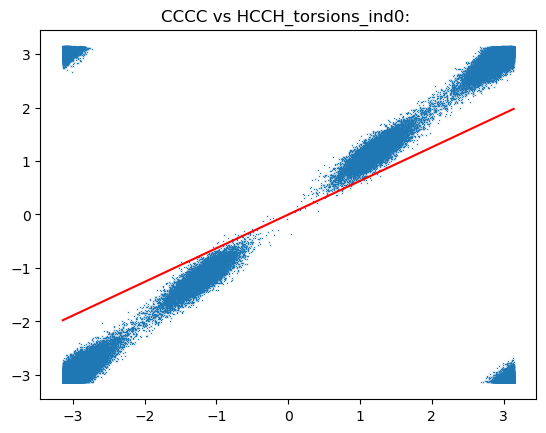

<Figure size 640x480 with 0 Axes>

In [58]:
plt.scatter(CCCC_torsion[:,0], HCCH_torsions[:,0],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,0],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,0])
print("r2:",r[0,1])
plt.title('CCCC vs HCCH_torsions_ind0: ')
plt.show()
plt.clf()

Explanation: The calculated coefficient of correlation for CCCC/HCCH_[0] pair is r^2: 0.6297988236828581 indicating a strong positive correlation between the two bonds. This shows a strong connection between the hydrogen atoms surrounding the shared carbon atoms that form the bond. This can lead to the prediction of bond changes around the central or shared carbon atom.

Line Parameters: [0.01457398 0.00213523]
r2: 0.02069789271917004


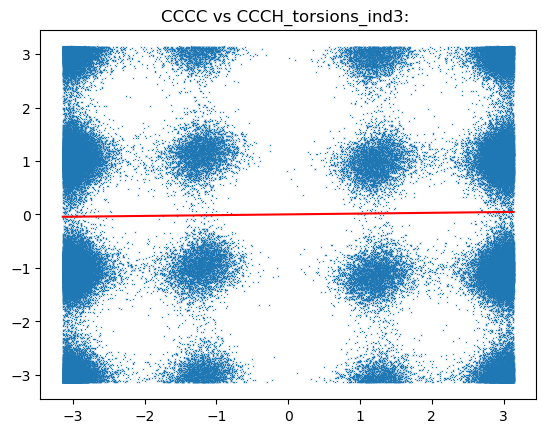

<Figure size 640x480 with 0 Axes>

In [59]:
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,3],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],CCCH_torsions[:,3],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCH_torsions[:,3]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,3])
print("r2:",r[0,1])
plt.title('CCCC vs CCCH_torsions_ind3: ')

plt.show()
plt.clf()

Line Parameters: [0.24143094 0.01707721]
r2: 0.2544183084853448


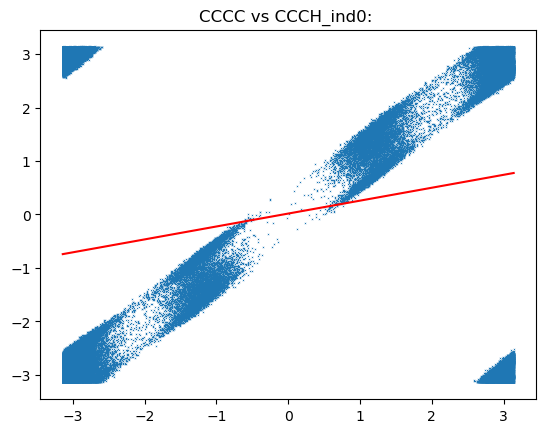

<Figure size 640x480 with 0 Axes>

In [60]:
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,0],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],CCCH_torsions[:,0],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCH_torsions[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,0])
print("r2:",r[0,1])
plt.title('CCCC vs CCCH_ind0: ')
plt.show()
plt.clf()

**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

Line Parameters: [-0.16506875 -0.10214145]
r2: -0.16297624736117533


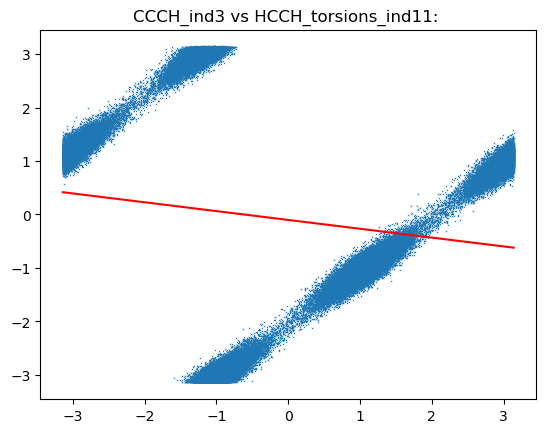

<Figure size 640x480 with 0 Axes>

In [61]:
plt.scatter(CCCH_torsions[:,3], HCCH_torsions[:,11],marker='x',s=0.05)

line_fit=np.polyfit(CCCH_torsions[:,3],HCCH_torsions[:,11],1)
x = np.linspace(min(CCCH_torsions[:,3]), max(HCCH_torsions[:,11]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCH_torsions[:,3], HCCH_torsions[:,11])
print("r2:",r[0,1])
plt.title('CCCH_ind3 vs HCCH_torsions_ind11: ')

plt.show()
plt.clf()

In [62]:
# np.concatenate(CCCH_torsions[:,3], HCCH_torsions[:,11])

HCCH_torsions[:,11]

array([-1.1382946 , -0.85829157, -0.589779  , ...,  1.1311486 ,
        0.9444534 ,  1.2585177 ], dtype=float32)

[  47.721245   80.72424    69.30828  ... -175.20325  -174.44164
 -174.492   ] [-65.219475 -49.176483 -33.791847 ...  64.810036  54.113194  72.10775 ]
[[ 176.93301]
 [-168.23586]
 [ 161.94046]
 ...
 [ 175.65141]
 [ 171.9751 ]
 [ 173.68988]]


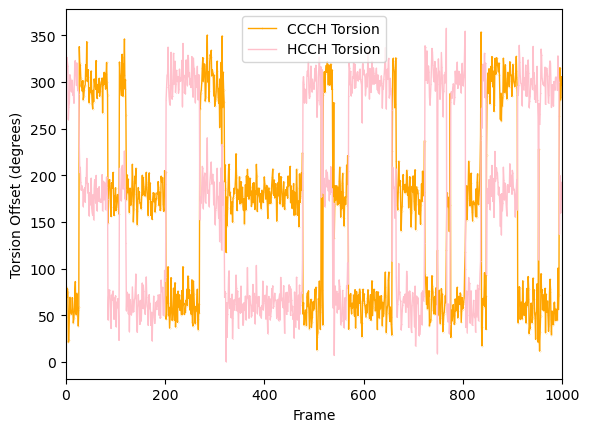

In [63]:
#print(np.where(CCCHtorsion<=0))
CCCH_tor_offset1=np.rad2deg(CCCH_torsions[:,3])
HCCH_tor_offset2=np.rad2deg(HCCH_torsions[:,11])
print(CCCH_tor_offset1, HCCH_tor_offset2)
print(CCCC_tor_offset)
for i in range(0,len(CCCH_tor_offset1)):
    if(CCCH_tor_offset1[i]<0):
        CCCH_tor_offset1[i]+=360
        
for i in range(0,len(HCCH_tor_offset2)):
    if(HCCH_tor_offset2[i]<0):
        HCCH_tor_offset2[i]+=360
# Add legend and labels
plt.xlabel('Frame')
plt.ylabel('Torsion Offset (degrees)')
# Show plot
#plt.plot(torsion1_offset, marker='x', markersize=0.1, linewidth=1, label='Torsion 1 Offset')
#plt.plot(torsion2_offset, marker='x', markersize=0.1, linewidth=1, label='Torsion 2 Offset')
plt.plot(CCCH_tor_offset1, marker='o', markersize=.1, linewidth=1, color='orange', label='CCCH Torsion')
plt.plot(HCCH_tor_offset2, marker='x', markersize=.1, linewidth=1, color='pink', label='HCCH Torsion')
plt.xlim([0,1000])
plt.legend()

Text(0.5, 0, 'frame')

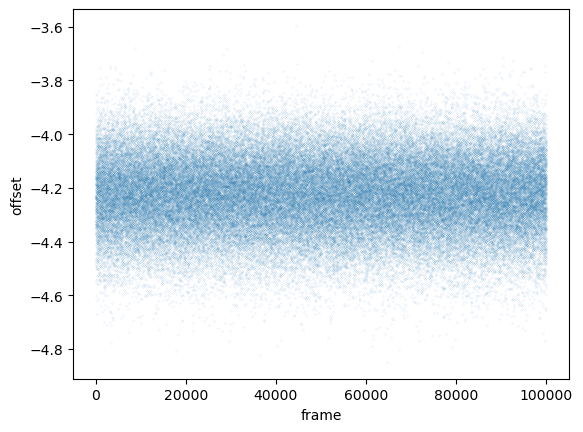

In [64]:
offset_diff = CCCH_torsions[:,3]- HCCH_torsions[:,11]
offset_diff = np.where(offset_diff>0, offset_diff - 2*np.pi, offset_diff)

plt.plot(offset_diff, marker=".",markersize=0.1, linestyle="None")
plt.ylabel("offset")
plt.xlabel("frame")

The results of the systematic offset obtained from CCCH and HCCH torsions ([54.415787 46.120663 36.836987 ... 52.453922 78.36445  58.61115 ] [-66.14827  -52.59424  -88.500626 ... -71.40288  -52.26681  -59.09088 ]), shows an offset in CCCH torsion being larger than that observed in HCCH by ~2 degree. this observation is seen in the patterns of the torsion plot above and the scatter plots.

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

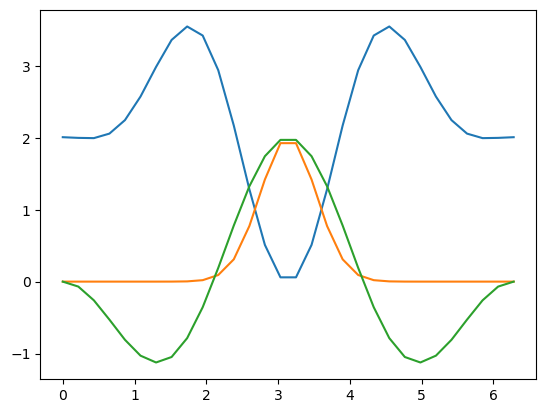

In [65]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang,CCCC_e)

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang,gauss_cor)

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor=TorsionCorrection(rad_ang)

plt.plot(rad_ang,torsion_cor)

***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [66]:
#RUN NEW MD SIMULATION HERE#

In [67]:
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2_cor1.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2_cor1.xml


In [68]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.197528690534442 kJ/mol
Potential energy after minimization is 12.695271386059607 kJ/mol


In [69]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,59.785124972251694,214.49919340710662
2000,41.024877994871986,207.58306429741847


In [70]:
os.path.join(workdir, "butane_rim.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_rim.xtc'

In [73]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_rim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,35.264303925300105,237.64368476970756,--
500000,999.9999999901769,60.32196236974231,423.6448951461489,6.16e+03
750000,1499.9999999783536,54.95916940738524,273.7507741655833,6.57e+03
1000000,1999.9999999665301,36.030287926299394,237.59654419894173,6.62e+03
1250000,2499.9999999547067,59.7458259365432,239.67267239268332,6.58e+03
1500000,2999.9999999428833,59.914408087704594,355.851146949906,6.77e+03
1750000,3499.99999993106,46.99549224864027,239.85798189805172,6.84e+03
2000000,3999.9999999192364,59.77144469792947,256.46669016710865,6.83e+03
2250000,4499.9999999992715,33.91667585484842,320.1392217810827,6.86e+03
2500000,5000.000000101135,47.937688847648715,372.159990943848,6.75e+03
2750000,5500.000000202998,50.50358739545922,255.87435500997972,6.81e+03
3000000,6000.000000304862,56.77518367160153,310.311325275411,6.73e+03
3250000,6500.000000406725,53.01231825154

In [74]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_rim.xtc"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x1b22d8e3c90>

In [75]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [76]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x1b22efa07d0>

In [77]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [78]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


(100000, 2)
[[1.9322717 2.0516982]
 [1.947415  2.0680306]
 [1.9982456 2.056517 ]
 ...
 [1.9889826 1.8973765]
 [1.9301124 1.9884092]
 [1.9263524 2.0508287]]


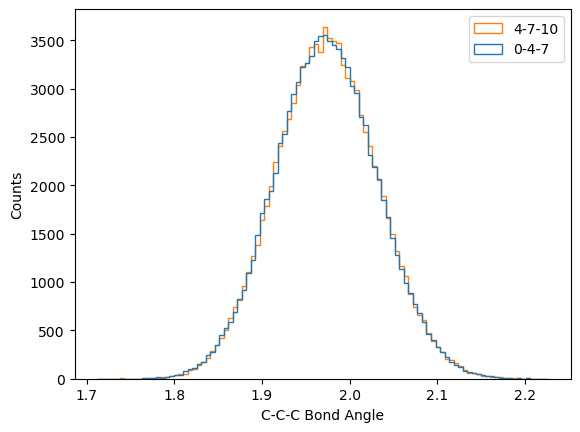

[[1.8197137 ]
 [1.447494  ]
 [0.94369876]
 ...
 [2.0520966 ]
 [1.2317446 ]
 [1.4827242 ]]
[[104.26191 ]
 [ 82.935295]
 [ 54.069954]
 ...
 [117.57647 ]
 [ 70.57377 ]
 [ 84.953835]]


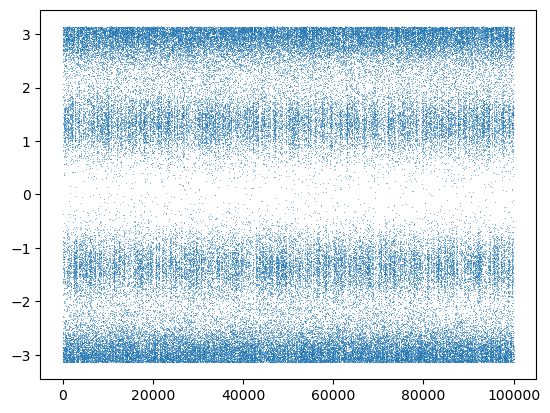

In [79]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

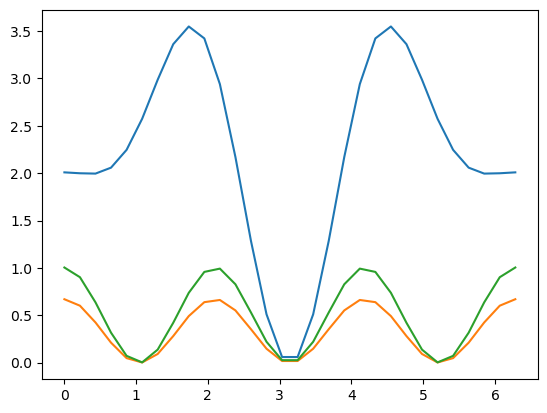

In [80]:
#Class Example

### Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

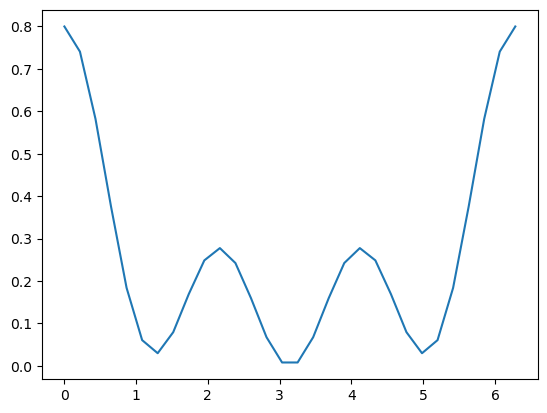

In [81]:
## Homework trial 1
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.2,3,0)
 e2=calc_torsion_energy(angle,-0.1499,2,3.1416)
 e3=calc_torsion_energy(angle,0.2,1,0)
 return e1+e2+e3

CCCC_e=CCCC_torsionE(rad_ang)

plt.plot(rad_ang,CCCC_e)

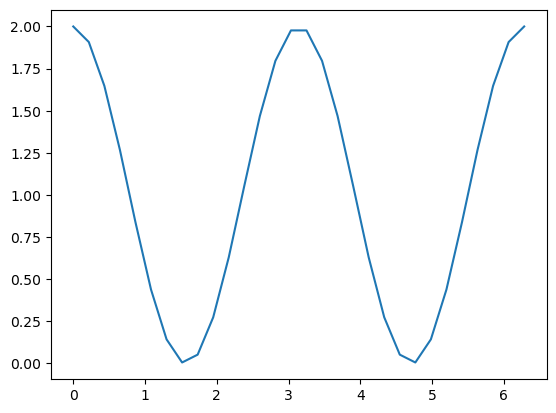

In [82]:
## Homework trial 2
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,-3,1,1.0472)
 e2=calc_torsion_energy(angle,1,2,6.2832)
 e3=calc_torsion_energy(angle,3,1,1.0472)
 return e1+e2+e3

#def CCCH_torsionE(angle):
# e1=calc_torsion_energy(angle,0.3347,3,0)
 #return e1

#def HCCH_torsionE(angle):
 #e1=calc_torsion_energy(angle,0.50208,3,0)
 #return e1

CCCC_e=CCCC_torsionE(rad_ang)
#CCCH_e=CCCH_torsionE(rad_ang)
#HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
#plt.plot(rad_ang,CCCH_e)
#plt.plot(rad_ang,HCCH_e)

In [83]:
#Compare New Dihedral Distribution HERE)
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2_cor1.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)


/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2_cor1.xml


In [84]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.197528690534442 kJ/mol
Potential energy after minimization is 12.695271386059607 kJ/mol


In [85]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,74.67830567902092,231.8499967034165
2000,42.850761439786666,365.2655927688404


In [86]:
os.path.join(workdir, "butane_cor1.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_cor1.xtc'

In [89]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_cor1.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,41.834993241967155,332.4208262831031,--
500000,999.9999999901769,49.581897828039175,324.3080067992111,5.75e+03
750000,1499.9999999783536,57.73462941851077,370.8469639108767,5.47e+03
1000000,1999.9999999665301,50.006339529973474,243.93433369478748,5.46e+03
1250000,2499.9999999547067,67.6988143972962,373.6258747700437,5.79e+03
1500000,2999.9999999428833,32.516580549707705,236.93643052907078,6.15e+03
1750000,3499.99999993106,41.28450872535484,372.8629075269334,6.39e+03
2000000,3999.9999999192364,59.99849324772501,345.5609824188792,6.44e+03
2250000,4499.9999999992715,41.80606662437222,348.3029119424573,6.61e+03
2500000,5000.000000101135,45.538832449927675,409.8346672096378,6.75e+03
2750000,5500.000000202998,50.34235834516953,231.2911253053061,6.8e+03
3000000,6000.000000304862,34.5545813874034,260.8843560482866,6.9e+03
3250000,6500.000000406725,56.12367690555433

In [90]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_cor1.xtc"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x1b22b2b6d10>

In [91]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

[0.520596   0.24872724 0.0950792  0.06805463 0.13022062 0.24175635
 0.18382392 0.07063298 0.01661578 0.00563408 0.00611155 0.01652028
 0.0707603  0.18793012 0.25019156 0.13082541 0.06907322 0.09301018
 0.25270612 0.52482952] [-3.1415925e+00 -2.8274333e+00 -2.5132740e+00 -2.1991148e+00
 -1.8849554e+00 -1.5707963e+00 -1.2566370e+00 -9.4247764e-01
 -6.2831843e-01 -3.1415915e-01  1.1920929e-07  3.1415939e-01
  6.2831867e-01  9.4247788e-01  1.2566372e+00  1.5707965e+00
  1.8849556e+00  2.1991150e+00  2.5132742e+00  2.8274336e+00
  3.1415927e+00]
[1.02495819e+00 1.98657119e-01 2.08174739e-02 7.22563422e-03
 2.62605649e-02 1.20130148e-01 1.46645388e-01 3.99160586e-02
 3.34225403e-03 3.50140898e-04 4.77464861e-04 4.10619781e-03
 4.21123968e-02 1.52088488e-01 1.24331838e-01 2.68653536e-02
 8.72169064e-03 2.12631079e-02 2.01490076e-01 1.01333988e+00] [-3.1415925  -2.8274333  -2.513274   -2.1991148  -1.8849555  -1.5707963
 -1.256637   -0.94247776 -0.6283185  -0.31415924  0.          0.31415924
  

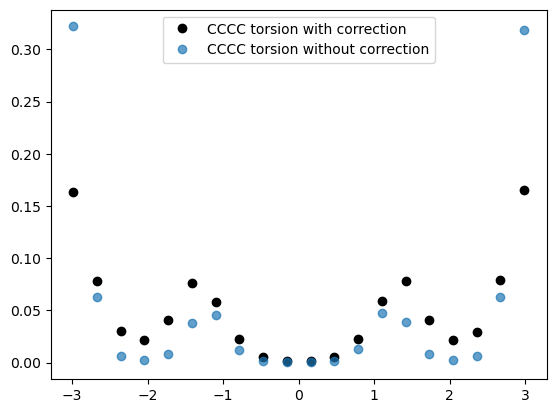

In [92]:
#Compare New Dihedral Distribution HERE)

# With Correction
traj_add_correction = md.load(os.path.join(workdir, "butane_cor1.xtc"), top=PDB_file_name)
CCCC_torsion_c = md.compute_dihedrals(traj_add_correction, [CCCC_index])
centers, density = histogram_bincenters(CCCC_torsion_c[:,0], 20)  # Removed the third argument
plt.plot(centers, density, "o", label="CCCC torsion with correction", color="black")

#Without Correction
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_index])
centers, density = histogram_bincenters(CCCC_torsion[:,0], 20)  # Removed the third argument
plt.plot(centers, density, "o", label="CCCC torsion without correction", color="tab:blue", alpha=0.7)

plt.legend()



**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##

![Screen%20Shot%202022-01-13%20at%202.00.42%20PM.png](attachment:Screen%20Shot%202022-01-13%20at%202.00.42%20PM.png)


In [93]:
#Plot LJ and Couloumb Potentionals Here

# Define LJ and Coulomb functions
def lj(r, sigma, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def coulomb(q1, q2, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * q1 * q2 / r

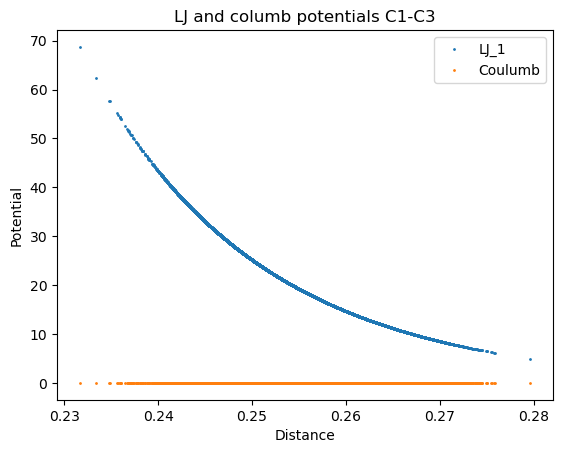

In [94]:
# Distance between between carbons 1 and 3 [0, 7] atom types [0,1]
atom_pair = np.array([[0, 7]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.3397710  # Sigma value for the first atom
epsilon_a = 0.4510352  # Epsilon value for the first atom
sigma_b = 0.3397710 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = -0.0932 # Charge of the first atom
qb = -0.0814  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_1")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials C1-C3')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()

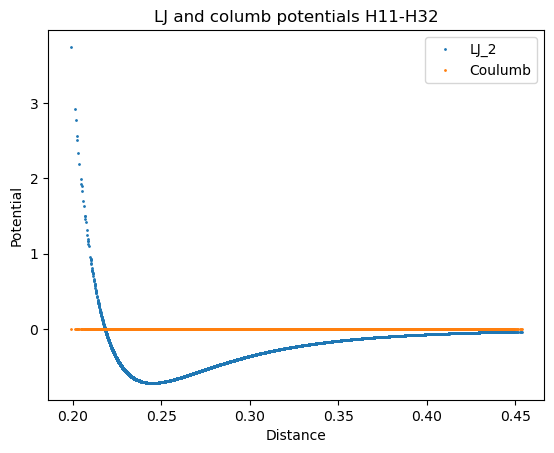

In [95]:
# Distance between between hydrogens 11 and 32 [1, 9] atom types [2,3]
atom_pair = np.array([[1, 9]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.2600177  # Sigma value for the first atom
epsilon_a = 0.0870272  # Epsilon value for the first atom
sigma_b = 0.2600177 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = 0.0324 # Charge of the first atom
qb = 0.0387  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_2")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials H11-H32')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()

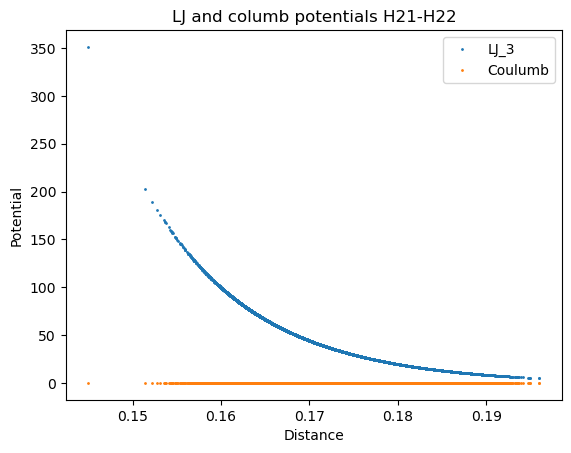

In [96]:
# Distance between between hydrogens 21 and 22 [5, 6] atom types [3]
atom_pair = np.array([[5, 6]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.2600177  # Sigma value for the first atom
epsilon_a = 0.0870272  # Epsilon value for the first atom
sigma_b = 0.2600177 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = 0.0387 # Charge of the first atom
qb = 0.0387  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_3")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials H21-H22')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()